In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/GEE_exports_Houston"
cat1_dir = os.path.join(base_path, "Cat1_NPZ")
cat2_dir = os.path.join(base_path, "Cat2_NPZ")
cat3_dir = os.path.join(base_path, "Cat3_NPZ")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset Class (FloodDataset)

In [ ]:
import torch
from torch.utils.data import Dataset
import numpy as np

class FloodDataset(Dataset):
    def __init__(self, cat1_dir, cat2_dir, cat3_dir, selected_indices, transform=None):
        self.samples = []
        self.transform = transform

        for label, path in enumerate([cat3_dir, cat1_dir, cat2_dir]):
            files = sorted(os.listdir(path))
            for i in selected_indices:
                if i < len(files):
                    self.samples.append((os.path.join(path, files[i]), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path, label = self.samples[idx]
        data = np.load(file_path)

        rainfall = data["rainfall"].astype(np.float32)   
        spatial = np.nan_to_num(data["spatial"].astype(np.float32), nan=0.0) 

        selected_channel_indices = [0, 2, 3, 4, 7, 8]
        spatial = spatial[selected_channel_indices, :, :]    

        mask = np.nan_to_num(data["mask"].astype(np.float32), nan=0.0)        

        rainfall_tensor = torch.tensor(rainfall)

        if self.transform:
          augmented = self.transform(
            image=spatial.transpose(1, 2, 0),  
            mask=mask                         
          )
          spatial_tensor = augmented["image"]               
          spatial_tensor = torch.nan_to_num(spatial_tensor, nan=0.0)
          mask_tensor = augmented["mask"].unsqueeze(0)      

        else:
            spatial_tensor = torch.tensor(spatial)
            mask_tensor = torch.tensor(mask).unsqueeze(0)

        return rainfall_tensor, spatial_tensor, mask_tensor, label


In [ ]:
from torch.utils.data import Subset

def stratified_split(dataset, label_value, train_ratio=0.7, val_ratio=0.2):
    indices = [i for i, (_, _, _, lbl) in enumerate(dataset) if lbl == label_value]
    total = len(indices)
    train_len = int(train_ratio * total)
    val_len = int(val_ratio * total)
    test_len = total - train_len - val_len

    return (
        Subset(dataset, indices[:train_len]),
        Subset(dataset, indices[train_len:train_len + val_len]),
        Subset(dataset, indices[train_len + val_len:])
    )


Create Dataset + Split by Category

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.4),
    A.RandomRotate90(p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),
    A.GridDistortion(p=0.2),
    A.Normalize(),
    ToTensorV2()
])


/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
<ipython-input-5-c67ba1efa79b>:10: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(p=0.3, alpha=1, sigma=50, alpha_affine=50),


In [ ]:
selected_indices = [0, 2, 3, 4, 7, 8]  

dataset_all = FloodDataset(cat1_dir, cat2_dir, cat3_dir, selected_indices, transform=None)  


train_cat1, val_cat1, test_cat1 = stratified_split(dataset_all, label_value=1)
train_cat2, val_cat2, test_cat2 = stratified_split(dataset_all, label_value=2)
train_cat3, val_cat3, test_cat3 = stratified_split(dataset_all, label_value=0)

from torch.utils.data import ConcatDataset

train_cat1.dataset.transform = train_augment
train_cat2.dataset.transform = train_augment
train_cat3.dataset.transform = train_augment

train_dataset = ConcatDataset([train_cat1, train_cat2, train_cat3])  

val_dataset = ConcatDataset([val_cat1, val_cat2, val_cat3])
test_dataset = ConcatDataset([test_cat1, test_cat2, test_cat3])



In [ ]:
from torch.utils.data import DataLoader

batch_size = 3 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True)


In [ ]:
rain, spatial, mask, label = next(iter(train_loader))
print("Rainfall:", rain.shape)
print("Spatial:", spatial.shape)
print("Mask:", mask.shape)
print("Label (category):", label)


Rainfall: torch.Size([3, 24, 1])
Spatial: torch.Size([3, 6, 512, 512])
Mask: torch.Size([3, 1, 512, 512])
Label (category): tensor([1, 0, 2])


In [ ]:
all_labels = []
for batch in train_loader:
    _, _, _, label = batch
    all_labels.extend(label.tolist())

print("Labels seen in entire training set:", set(all_labels))


Labels seen in entire training set: {0, 1, 2}


FloodSegmentationModel

In [ ]:
import torch
import torch.nn as nn
import torchvision.models.segmentation as models

class RainLSTMEncoder(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 512 * 512)

    def forward(self, x): 
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  
        return out.view(-1, 1, 512, 512)  

class AttentionFusion(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Conv2d(in_channels, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):  
        combined = torch.cat([x1, x2], dim=1)  
        weights = self.attn(combined)          
        return weights * x1 + (1 - weights) * x2


In [ ]:
class FloodSegmentationModel(nn.Module):
    def __init__(self, lstm_hidden=64, lstm_layers=1, cnn_channels=64, spatial_channels=6):
        super(FloodSegmentationModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True
        )

        self.spatial_conv = nn.Sequential(
            nn.Conv2d(in_channels=spatial_channels, out_channels=cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=cnn_channels, out_channels=cnn_channels, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        self.fusion = nn.Sequential(
            nn.Conv2d(in_channels=cnn_channels + lstm_hidden, out_channels=64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        )

    def forward(self, rainfall, spatial):
      
        lstm_out, _ = self.lstm(rainfall)
        lstm_feat = lstm_out[:, -1, :].unsqueeze(-1).unsqueeze(-1)  
        lstm_feat = lstm_feat.expand(-1, -1, 512, 512)              

        spatial_feat = self.spatial_conv(spatial)  
        x = torch.cat([spatial_feat, lstm_feat], dim=1)  
        out = self.fusion(x)
        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FloodSegmentationModel(spatial_channels=6).to(device)


Step 3: Training Loop Setup 📌 1. Loss Function & Optimizer

In [ ]:
import torch
import torch.nn as nn

class WeightedBCEFocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, lambda_bce=0.5, lambda_focal=0.5):
        super().__init__()
        self.weight = weight
        self.gamma = gamma
        self.lambda_bce = lambda_bce
        self.lambda_focal = lambda_focal
        self.bce = nn.BCEWithLogitsLoss(pos_weight=weight)

    def focal_loss(self, logits, targets):
        probs = torch.sigmoid(logits).clamp(1e-7, 1 - 1e-7)
        pt = probs * targets + (1 - probs) * (1 - targets)
        focal = -(1 - pt) ** self.gamma * torch.log(pt)
        return focal.mean()

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        focal_loss = self.focal_loss(logits, targets)
        return self.lambda_bce * bce_loss + self.lambda_focal * focal_loss


In [ ]:
import cv2
import numpy as np

def post_process(pred_mask, kernel_size=5):
   
    pred_mask_np = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)  

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    cleaned_mask = cv2.morphologyEx(pred_mask_np, cv2.MORPH_OPEN, kernel)

    cleaned_mask = torch.tensor(cleaned_mask).unsqueeze(0).float().to(pred_mask.device)

    return cleaned_mask


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

pos_weight = torch.tensor([3.0]).to(device)

criterion = WeightedBCEFocalLoss(weight=pos_weight, gamma=2.0, lambda_bce=0.3, lambda_focal=0.7)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for rainfall, spatial, mask, label in loader:
        rainfall = rainfall.to(device)
        spatial = spatial.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        output = model(rainfall, spatial)

        loss = criterion(output, mask)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * rainfall.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss


In [ ]:
import cv2
import numpy as np
import torch

def post_process(pred_mask, kernel_size=5):
    pred_mask_np = pred_mask.squeeze(0).cpu().numpy().astype(np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    cleaned_mask = cv2.morphologyEx(pred_mask_np, cv2.MORPH_OPEN, kernel)
    cleaned_mask = torch.tensor(cleaned_mask).unsqueeze(0).float().to(pred_mask.device)
    return cleaned_mask

def evaluate(model, loader, criterion, device, thresholds={0: 0.5, 1: 0.4, 2: 0.3}):
    model.eval()
    val_loss = 0.0
    dice_scores = []
    iou_scores = []  

    with torch.no_grad():
        for rainfall, spatial, mask, label in loader:
            rainfall = rainfall.to(device)
            spatial = spatial.to(device)
            mask = mask.to(device)
            label = label.to(device)

            output = model(rainfall, spatial)

            loss = criterion(output, mask)
            val_loss += loss.item() * rainfall.size(0)

            preds = torch.sigmoid(output)

            for i in range(preds.size(0)):
                thres = thresholds[int(label[i].item())]
                pred_binary = (preds[i] > thres).float()

                pred_binary = post_process(pred_binary)

                intersection = (pred_binary * mask[i]).sum()
                union = pred_binary.sum() + mask[i].sum()

                dice = (2 * intersection + 1e-7) / (union + 1e-7)
                dice_scores.append(dice.item())

                union_area = ((pred_binary + mask[i]) >= 1).sum()
                iou = (intersection + 1e-7) / (union_area + 1e-7)
                iou_scores.append(iou.item())

    epoch_loss = val_loss / len(loader.dataset)
    mean_dice = sum(dice_scores) / len(dice_scores)
    mean_iou = sum(iou_scores) / len(iou_scores)

    return epoch_loss, mean_dice, mean_iou  



In [ ]:
num_epochs = 20
best_dice = 0.0

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice, val_iou = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")


Epoch 1/20 | Train Loss: 0.4031 | Val Loss: 0.3902 | Val Dice: 0.2184 | IoU: 0.1307
✅ Best model saved!
Epoch 2/20 | Train Loss: 0.3894 | Val Loss: 0.3829 | Val Dice: 0.5679 | IoU: 0.4759
✅ Best model saved!
Epoch 3/20 | Train Loss: 0.3765 | Val Loss: 0.3701 | Val Dice: 0.5600 | IoU: 0.4703
Epoch 4/20 | Train Loss: 0.3678 | Val Loss: 0.3551 | Val Dice: 0.5416 | IoU: 0.4568
Epoch 5/20 | Train Loss: 0.3613 | Val Loss: 0.3572 | Val Dice: 0.5639 | IoU: 0.4731
Epoch 6/20 | Train Loss: 0.3537 | Val Loss: 0.3468 | Val Dice: 0.5533 | IoU: 0.4657
Epoch 7/20 | Train Loss: 0.3451 | Val Loss: 0.3451 | Val Dice: 0.5627 | IoU: 0.4723
Epoch 8/20 | Train Loss: 0.3435 | Val Loss: 0.3398 | Val Dice: 0.5643 | IoU: 0.4734
Epoch 9/20 | Train Loss: 0.3361 | Val Loss: 0.3338 | Val Dice: 0.5635 | IoU: 0.4728
Epoch 10/20 | Train Loss: 0.3308 | Val Loss: 0.3305 | Val Dice: 0.5661 | IoU: 0.4746
Epoch 11/20 | Train Loss: 0.3240 | Val Loss: 0.3230 | Val Dice: 0.4539 | IoU: 0.4069
Epoch 12/20 | Train Loss: 0.3264 |

In [ ]:
def visualize_predictions(model, loader, device, thresholds={0: 0.5, 1: 0.4, 2: 0.3}, num_samples=3):
    import matplotlib.pyplot as plt
    import numpy as np

    model.eval()
    shown = 0

    with torch.no_grad():
        for rainfall, spatial, mask, label in loader:
            rainfall = rainfall.to(device)
            spatial = spatial.to(device)
            mask = mask.to(device)
            label = label.to(device)

            output = model(rainfall, spatial)
            preds = torch.sigmoid(output)

            for i in range(rainfall.size(0)):
                cat = int(label[i].item())
                threshold = thresholds.get(cat, 0.5)
                pred_mask = (preds[i] > threshold).float()
                pred_mask = post_process(pred_mask)

                rainfall_input = rainfall[i].detach().cpu().numpy() 
                rainfall_mean = rainfall_input.mean() * np.ones((512, 512)) 

                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(mask[i].squeeze(0).cpu(), cmap='gray')
                axs[0].set_title(f'Ground Truth Mask (Cat-{cat})')

                axs[1].imshow(pred_mask.squeeze(0).cpu(), cmap='gray')
                axs[1].set_title('Predicted Mask')

                axs[2].plot(rainfall_input.squeeze(), color='blue')
                axs[2].set_title("Rainfall (24h)")
                axs[2].set_xlabel("Hour")
                axs[2].set_ylabel("mm/hr")
                axs[2].grid(True)


                for ax in axs:
                    ax.axis('off')

                plt.tight_layout()
                plt.show()

                shown += 1
                if shown >= num_samples:
                    return


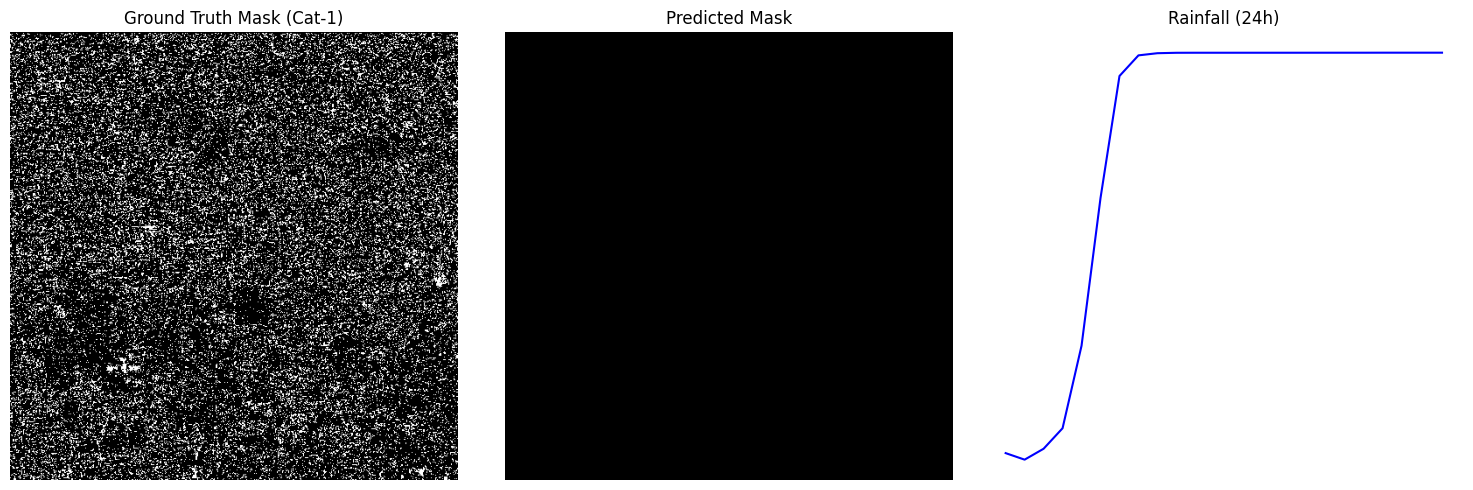

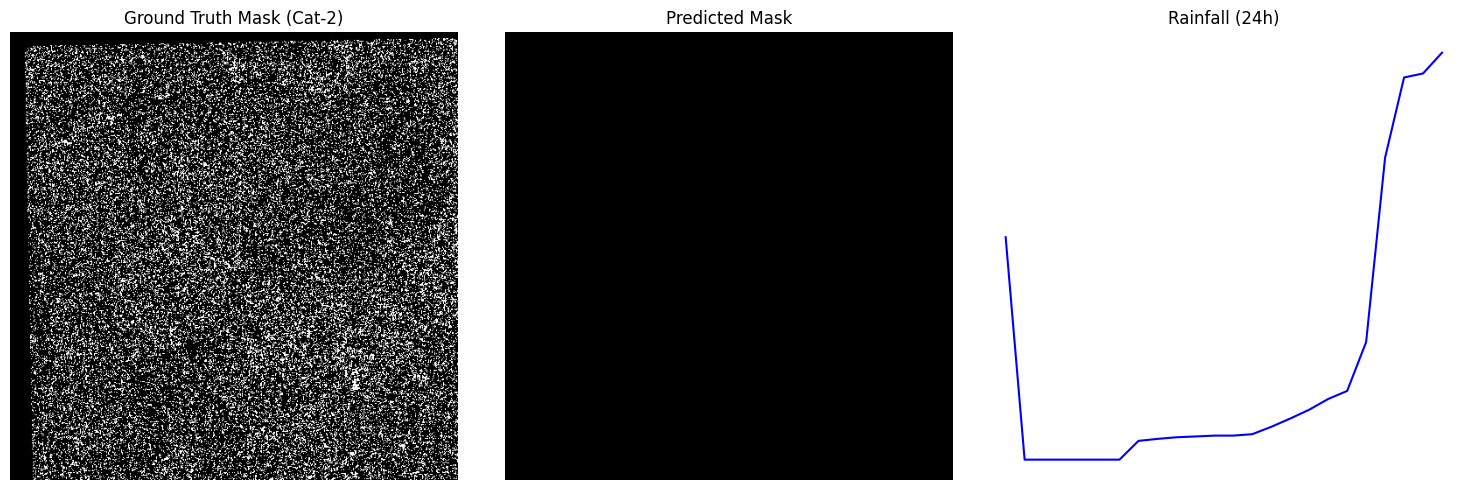

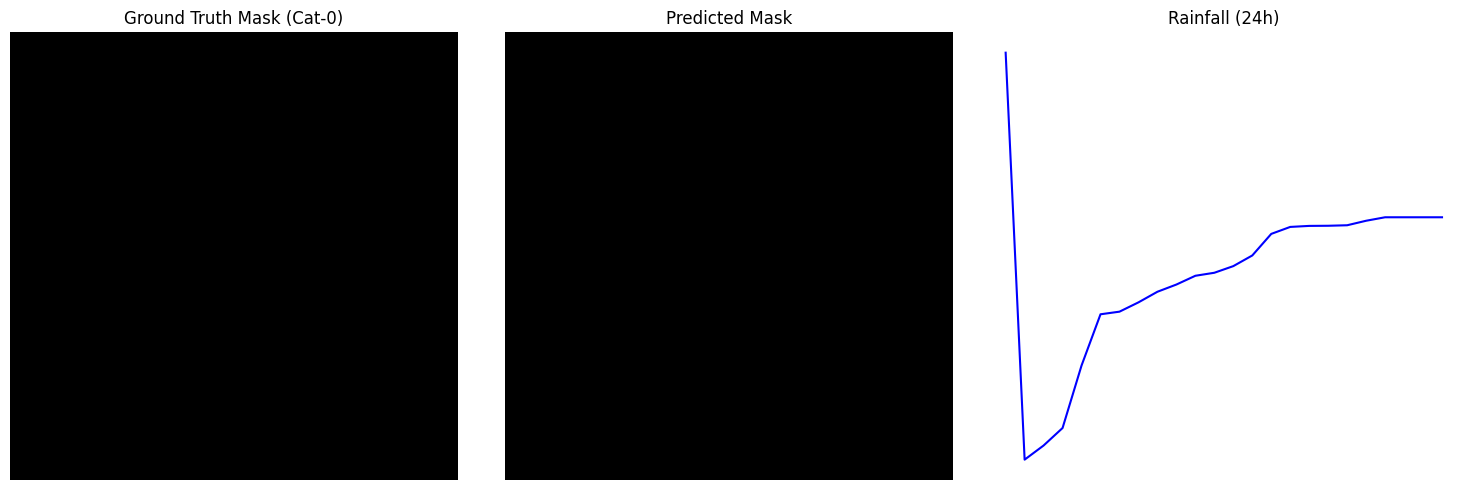

In [ ]:
visualize_predictions(model, val_loader, device, thresholds={0:0.05, 1:0.1, 2:0.3}, num_samples=3)


In [ ]:
def tune_thresholds(model, loader, device, thresholds_to_try=[0.2, 0.3, 0.4, 0.5, 0.6]):
    import numpy as np
    from collections import defaultdict

    model.eval()
    best_dice = {0: 0, 1: 0, 2: 0}
    best_thresh = {0: 0.5, 1: 0.5, 2: 0.5}
    dice_per_cat = defaultdict(lambda: defaultdict(list))

    with torch.no_grad():
        for thresh in thresholds_to_try:
            for rainfall, spatial, mask, label in loader:
                rainfall = rainfall.to(device)
                spatial = spatial.to(device)
                mask = mask.to(device)
                label = label.to(device)

                output = model(rainfall, spatial)
                probs = torch.sigmoid(output)

                for i in range(probs.size(0)):
                    cat = int(label[i].item())
                    pred = (probs[i] > thresh).float()
                    pred = post_process(pred)

                    intersection = (pred * mask[i]).sum()
                    union = pred.sum() + mask[i].sum()
                    dice = (2 * intersection + 1e-7) / (union + 1e-7)

                    dice_per_cat[cat][thresh].append(dice.item())

    for cat in [0, 1, 2]:
        for thresh in thresholds_to_try:
            avg_dice = np.mean(dice_per_cat[cat][thresh]) if dice_per_cat[cat][thresh] else 0
            if avg_dice > best_dice[cat]:
                best_dice[cat] = avg_dice
                best_thresh[cat] = thresh

    print("Best Thresholds per Category:")
    for cat in [0, 1, 2]:
        print(f"Cat-{cat}: Threshold = {best_thresh[cat]}, Dice = {best_dice[cat]:.4f}")

    return best_thresh


In [ ]:
tuned_thresholds = tune_thresholds(model, val_loader, device, thresholds_to_try=[0.2, 0.3, 0.4, 0.5, 0.6])


Best Thresholds per Category:
Cat-0: Threshold = 0.4, Dice = 1.0000
Cat-1: Threshold = 0.3, Dice = 0.2979
Cat-2: Threshold = 0.2, Dice = 0.3797


HyperParameter using Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna


In [ ]:
def objective(trial):
    pos_weight_val = trial.suggest_float('pos_weight', 1.0, 5.0)
    gamma = trial.suggest_float('gamma', 1.0, 4.0)
    lambda_bce = trial.suggest_float('lambda_bce', 0.0, 1.0)
    lambda_focal = 1.0 - lambda_bce

    lr = trial.suggest_float('lr', 1e-5, 5e-4)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3)

    lstm_hidden = trial.suggest_categorical('lstm_hidden', [32, 64, 128])
    lstm_layers = trial.suggest_categorical('lstm_layers', [1, 2])
    cnn_channels = trial.suggest_categorical('cnn_channels', [32, 64, 128])

    batch_size = trial.suggest_categorical('batch_size', [2, 4, 8])

    model = FloodSegmentationModel(
        lstm_hidden=lstm_hidden,
        lstm_layers=lstm_layers,
        cnn_channels=cnn_channels
    ).to(device)

    pos_weight_tensor = torch.tensor([pos_weight_val]).to(device)
    criterion = WeightedBCEFocalLoss(
        weight=pos_weight_tensor,
        gamma=gamma,
        lambda_bce=lambda_bce,
        lambda_focal=lambda_focal
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

    for epoch in range(5):
        train_one_epoch(model, train_loader, optimizer, criterion, device)

    _, val_dice, val_iou = evaluate(model, val_loader, criterion, device)

    return 1.0 - val_dice  


In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)  


[I 2025-04-28 03:56:23,271] A new study created in memory with name: no-name-08b7457f-7b41-4894-9a02-4165873d0b6c
[I 2025-04-28 03:56:40,987] Trial 0 finished with value: 0.6666666666653023 and parameters: {'pos_weight': 2.0158900742654478, 'gamma': 1.010001102499288, 'lambda_bce': 0.08144714058995917, 'lr': 0.00044911936933718973, 'weight_decay': 0.00098216216686519, 'lstm_hidden': 128, 'lstm_layers': 2, 'cnn_channels': 64, 'batch_size': 8}. Best is trial 0 with value: 0.6666666666653023.
[I 2025-04-28 03:56:53,688] Trial 1 finished with value: 0.43228079875310266 and parameters: {'pos_weight': 1.8487152332029582, 'gamma': 2.67798207441711, 'lambda_bce': 0.9475274325741444, 'lr': 2.254424264752914e-05, 'weight_decay': 7.450725845891159e-05, 'lstm_hidden': 128, 'lstm_layers': 1, 'cnn_channels': 128, 'batch_size': 4}. Best is trial 1 with value: 0.43228079875310266.
[I 2025-04-28 03:57:04,894] Trial 2 finished with value: 0.44440912206967675 and parameters: {'pos_weight': 1.311411157105

KeyboardInterrupt: 

In [ ]:
print("Best trial:")
trial = study.best_trial
print(f"  Dice Score: {1.0 - trial.value:.4f}")
print("  Params:")
for key, val in trial.params.items():
    print(f"    {key}: {val}")


Best trial:
  Dice Score: 0.5677
  Params:
    pos_weight: 1.8487152332029582
    gamma: 2.67798207441711
    lambda_bce: 0.9475274325741444
    lr: 2.254424264752914e-05
    weight_decay: 7.450725845891159e-05
    lstm_hidden: 128
    lstm_layers: 1
    cnn_channels: 128
    batch_size: 4


full training:

In [ ]:
model = FloodSegmentationModel(
    lstm_hidden=128,
    lstm_layers=1,
    cnn_channels=32,
    spatial_channels=6  
).to(device)


In [ ]:
pos_weight_tensor = torch.tensor([3.62967469065213]).to(device)

criterion = WeightedBCEFocalLoss(
    weight=pos_weight_tensor,
    gamma=3.947694081035149,
    lambda_bce=0.7307876473036867,
    lambda_focal=1.0 - 0.7307876473036867  
)


In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3.998062439460336e-05,
    weight_decay=0.00033487051007358946
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=2, pin_memory=True)


In [ ]:
best_dice = 0.0

for epoch in range(40):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice, val_iou = evaluate(model, val_loader, criterion, device)  

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/40 | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Dice: {val_dice:.4f} | Val IoU: {val_iou:.4f}")

    if val_dice > best_dice:
        best_dice = val_dice
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Best model saved!")


Epoch 1/40 | Train Loss: 0.7247 | Val Loss: 0.7189 | Val Dice: 0.2261 | Val IoU: 0.1366
✅ Best model saved!
Epoch 2/40 | Train Loss: 0.7211 | Val Loss: 0.7227 | Val Dice: 0.2344 | Val IoU: 0.1424
✅ Best model saved!
Epoch 3/40 | Train Loss: 0.7196 | Val Loss: 0.7047 | Val Dice: 0.2161 | Val IoU: 0.1298
Epoch 4/40 | Train Loss: 0.7174 | Val Loss: 0.7066 | Val Dice: 0.2227 | Val IoU: 0.1337
Epoch 5/40 | Train Loss: 0.7013 | Val Loss: 0.6920 | Val Dice: 0.2084 | Val IoU: 0.1240
Epoch 6/40 | Train Loss: 0.7055 | Val Loss: 0.7137 | Val Dice: 0.2351 | Val IoU: 0.1429
✅ Best model saved!
Epoch 7/40 | Train Loss: 0.7072 | Val Loss: 0.7063 | Val Dice: 0.2290 | Val IoU: 0.1386
Epoch 8/40 | Train Loss: 0.7095 | Val Loss: 0.7099 | Val Dice: 0.2350 | Val IoU: 0.1428
Epoch 9/40 | Train Loss: 0.7045 | Val Loss: 0.7023 | Val Dice: 0.2289 | Val IoU: 0.1386
Epoch 10/40 | Train Loss: 0.6997 | Val Loss: 0.7009 | Val Dice: 0.5622 | Val IoU: 0.4716
✅ Best model saved!
Epoch 11/40 | Train Loss: 0.7007 | Val 

In [ ]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


FloodSegmentationModel(
  (lstm): LSTM(1, 128, batch_first=True)
  (spatial_conv): Sequential(
    (0): Conv2d(6, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (fusion): Sequential(
    (0): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [ ]:
test_loss, test_dice, test_iou = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Dice: {test_dice:.4f} | Test IoU: {test_iou:.4f}")


Test Loss: 0.7045 | Test Dice: 0.5735 | Test IoU: 0.4798
